In [15]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from scipy.integrate import quad, trapz, cumtrapz

import scipy.stats
import scipy.optimize
from scipy.signal import find_peaks, peak_widths

%pylab inline

from lmfit import minimize, Parameters, Model, fit_report

S_n = 7.246 #энергия отрыва нейтрона
S_2n = 17.02

total_GT = 55.54

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
from matplotlib import rc
rc("ps", fonttype=42)

In [3]:
def gauss(x, mu, sigma, k):
    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def line(x, a, b):
    return a*x+b

def breit_vigner2_1(x, M, w, alpha):
    G = alpha * (w ** 2)
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов
def breit_vigner2_2(x, M, w, alpha, beta):
    G = alpha*(w**2) + beta*(w**3)
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов
def breit_vigner2_3(x, M, w, alpha, beta):
    G = alpha*(w**2) - beta*(w**3)
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов



def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner4(x, M, w,  G1):
    a = M/(2*np.pi*G1)
    b = 1 + np.square(2*(x-w)/G1)
    return np.round(a/b, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def QFC_back4(x, E_qf, N_0, Q_EC, S_p, E_projectile):
    W = 22
    T = 100
    E_t_gs = E_projectile - Q_EC
    E_0 = E_t_gs - S_p
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

In [4]:
data_to_fit_x = np.linspace(0,25, 4000)

## data from 1999

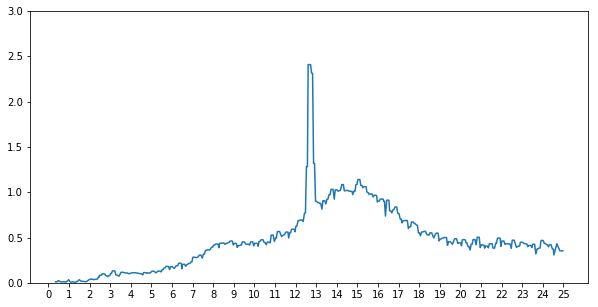

In [5]:
data1985 = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_fig2.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
#data1985['x'] = -data1985['x'] + 120

plt.figure(figsize=(10,5))
plt.plot(data1985['x'].values, data1985['y'].values)
plt.xticks(np.arange(0,26,1))
plt.ylim(0,3)
plt.show()

In [6]:
total_mod = Model(breit_vigner3,prefix='pigmy1_') \
+Model(breit_vigner3, prefix='pigmy2_') \
+Model(breit_vigner3, prefix='IAS_') \
+Model(breit_vigner3, prefix='GTR_') \
+Model(QFC_back4, prefix='QFC_')

total_mod.set_param_hint('pigmy1_w', value=9, min=5, max=11)
total_mod.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=1.5)
total_mod.set_param_hint('pigmy1_M', value=5, min=0.1, max=10)

total_mod.set_param_hint('pigmy2_w', value=4, min=2, max=5)
total_mod.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=1.5)
total_mod.set_param_hint('pigmy2_M', value=1, min=0.1, max=2)

total_mod.set_param_hint('IAS_w', value=13.5, min=12, max=14)
total_mod.set_param_hint('IAS_G1', value=0.1, min=0.01, max=3)
total_mod.set_param_hint('IAS_M', value=1, min=0.1, max=20)

total_mod.set_param_hint('GTR_w', value=15, min=11, max=16)
total_mod.set_param_hint('GTR_G1', value=2, min=2, max=5)
total_mod.set_param_hint('GTR_M', value=5, min=0.1, max= 30)

total_mod.set_param_hint('QFC_E_qf', value=400, min=50, max=420)
total_mod.set_param_hint('QFC_N_0', value=8, min=1, max=15)
total_mod.set_param_hint('QFC_Q_EC', value=0.662, vary=False)
total_mod.set_param_hint('QFC_S_p', value=7.699, vary=False)
total_mod.set_param_hint('QFC_E_projectile', value=159.1, vary=False)

pars = total_mod.make_params()

total_mod_result = total_mod.fit(data1985['y'].values, pars, x=data1985['x'].values, 
                                 method='differential_evolution')

print(total_mod_result.fit_report())

[[Model]]
    ((((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='pigmy2_')) + Model(breit_vigner3, prefix='IAS_')) + Model(breit_vigner3, prefix='GTR_')) + Model(QFC_back4, prefix='QFC_'))
[[Fit Statistics]]
    # function evals   = 22126
    # data points      = 449
    # variables        = 14
    chi-square         = 1.516
    reduced chi-square = 0.003
    Akaike info crit   = -2527.348
    Bayesian info crit = -2469.850
[[Variables]]
    pigmy1_M:           0.41639825 (init= 5)
    pigmy1_w:           8.60708830 (init= 9)
    pigmy1_G1:          1.49964548 (init= 0.1)
    pigmy2_M:           0.10009336 (init= 1)
    pigmy2_w:           3.26759050 (init= 4)
    pigmy2_G1:          1.48979171 (init= 0.1)
    IAS_M:              0.24502839 (init= 1)
    IAS_w:              12.7155192 (init= 13.5)
    IAS_G1:             0.12291020 (init= 0.1)
    GTR_M:              2.56543690 (init= 5)
    GTR_w:              14.8583396 (init= 15)
    GTR_G1:             2.8138

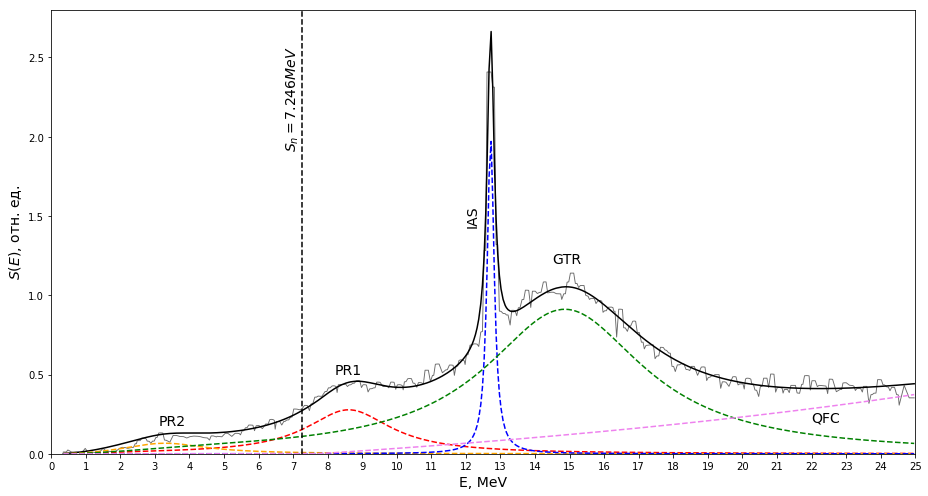

In [7]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data1985['x'].values, data1985['y'].values, 'dimgrey', linewidth=0.9, label='experimental data')
plt.plot(data1985['x'].values, total_mod_result.best_fit, 'k', ls='-', label='total fit')
plt.plot(data1985['x'].values, total_mod_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
plt.plot(data1985['x'].values, total_mod_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
plt.plot(data1985['x'].values, total_mod_comps['IAS_'], 'b--', label='IAS')
plt.plot(data1985['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data1985['x'].values, total_mod_comps['QFC_'], 'violet', ls='--', label='QFC')

plt.axvline(S_n, c='black', ls='--',)
plt.text(S_n-0.5, 2.5, '$S_{n}=7.246 MeV$', rotation=90, fontsize=14)

plt.text(14.5, 1.2, 'GTR',  fontsize=14)
plt.text(22, 0.2, 'QFC',  fontsize=14)
plt.text(12.0, 1.5, 'IAS',  fontsize=14, rotation=90)
plt.text(3.1, 0.18, 'PR2',  fontsize=14)
plt.text(8.2, 0.5, 'PR1',  fontsize=14)

plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, отн. ед.', rotation=90, fontsize=14)
plt.ylim(0,2.8)
plt.xlim(0,25)
plt.xticks(np.arange(0,26,1))
#plt.show()
plt.tight_layout()
#plt.savefig('Xe127_decomposition_BW.png', format='png', dpi=500)
#plt.show()

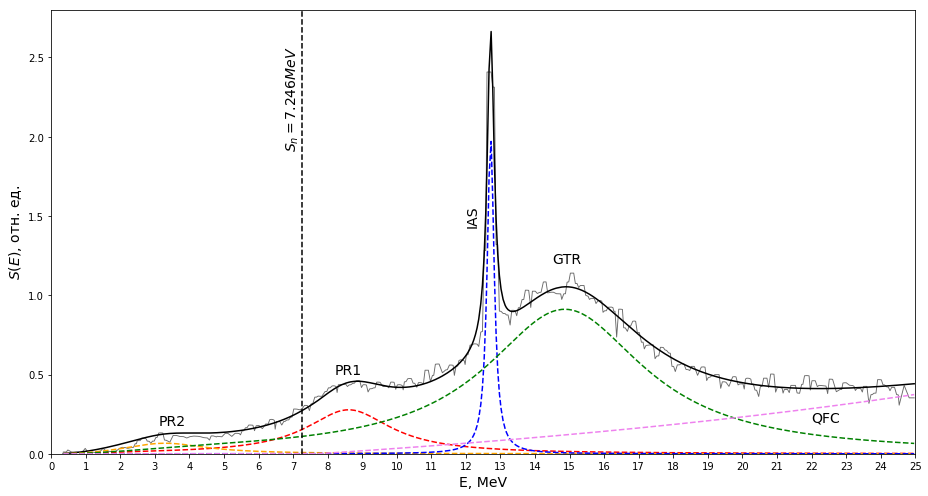

In [9]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data1985['x'].values, data1985['y'].values, 'dimgrey', linewidth=0.9, label='experimental data')
plt.plot(data1985['x'].values, total_mod_result.best_fit, 'k', ls='-', label='total fit')
plt.plot(data1985['x'].values, total_mod_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
plt.plot(data1985['x'].values, total_mod_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
plt.plot(data1985['x'].values, total_mod_comps['IAS_'], 'b--', label='IAS')
plt.plot(data1985['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data1985['x'].values, total_mod_comps['QFC_'], 'violet', ls='--', label='QFC')

plt.axvline(S_n, c='black', ls='--',)
plt.text(S_n-0.5, 2.5, '$S_{n}=7.246 MeV$', rotation=90, fontsize=14)

plt.text(14.5, 1.2, 'GTR',  fontsize=14)
plt.text(22, 0.2, 'QFC',  fontsize=14)
plt.text(12.0, 1.5, 'IAS',  fontsize=14, rotation=90)
plt.text(3.1, 0.18, 'PR2',  fontsize=14)
plt.text(8.2, 0.5, 'PR1',  fontsize=14)

plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, отн. ед.', rotation=90, fontsize=14)
plt.ylim(0,2.8)
plt.xlim(0,25)
plt.xticks(np.arange(0,26,1))
#plt.show()
plt.tight_layout()
#plt.savefig('Xe127_decomposition_BW.svg', format='svg')
#plt.show()

In [10]:
total_mod_gauss = Model(gauss,prefix='pigmy1_') \
+Model(gauss, prefix='pigmy2_') \
+Model(gauss, prefix='IAS_') \
+Model(gauss, prefix='GTR_') \
+Model(QFC_back4, prefix='QFC_')

total_mod_gauss.set_param_hint('pigmy1_mu', value=9, min=5, max=11)
total_mod_gauss.set_param_hint('pigmy1_sigma', value=0.1, min=0.1, max=3)
total_mod_gauss.set_param_hint('pigmy1_k', value=5, min=0.1, max=10)

total_mod_gauss.set_param_hint('pigmy2_mu', value=4, min=0.1, max=6)
total_mod_gauss.set_param_hint('pigmy2_sigma', value=0.1, min=0.1, max=1.0)
total_mod_gauss.set_param_hint('pigmy2_k', value=1, min=0.1, max=2)

total_mod_gauss.set_param_hint('IAS_mu', value=13.5, min=12, max=14)
total_mod_gauss.set_param_hint('IAS_sigma', value=0.1, min=0.01, max=3)
total_mod_gauss.set_param_hint('IAS_k', value=1, min=0.1, max=10)

total_mod_gauss.set_param_hint('GTR_mu', value=15, min=11, max=16)
total_mod_gauss.set_param_hint('GTR_sigma', value=2, min=2, max=5)
total_mod_gauss.set_param_hint('GTR_k', value=5, min=0.1, max= 30)

total_mod_gauss.set_param_hint('QFC_E_qf', value=400, min=50, max=420)
total_mod_gauss.set_param_hint('QFC_N_0', value=8, min=1, max=10)
total_mod_gauss.set_param_hint('QFC_Q_EC', value=0.662, vary=False)
total_mod_gauss.set_param_hint('QFC_S_p', value=7.699, vary=False)
total_mod_gauss.set_param_hint('QFC_E_projectile', value=159.1, vary=False)

pars_gauss = total_mod_gauss.make_params()

total_mod_gauss_result = total_mod_gauss.fit(data1985['y'].values, pars_gauss, x=data1985['x'].values, 
                                 method='differential_evolution')

print(total_mod_gauss_result.fit_report())

[[Model]]
    ((((Model(gauss, prefix='pigmy1_') + Model(gauss, prefix='pigmy2_')) + Model(gauss, prefix='IAS_')) + Model(gauss, prefix='GTR_')) + Model(QFC_back4, prefix='QFC_'))
[[Fit Statistics]]
    # function evals   = 44941
    # data points      = 449
    # variables        = 14
    chi-square         = 1.047
    reduced chi-square = 0.002
    Akaike info crit   = -2693.426
    Bayesian info crit = -2635.927
[[Variables]]
    pigmy1_mu:          8.39527050 (init= 9)
    pigmy1_sigma:       1.83602957 (init= 0.1)
    pigmy1_k:           0.36330580 (init= 5)
    pigmy2_mu:          3.58117759 (init= 4)
    pigmy2_sigma:       1          (init= 0.1)
    pigmy2_k:           0.10738435 (init= 1)
    IAS_mu:             12.7157223 (init= 13.5)
    IAS_sigma:          0.11628301 (init= 0.1)
    IAS_k:              1.83252818 (init= 1)
    GTR_mu:             14.6103843 (init= 15)
    GTR_sigma:          2.16252345 (init= 2)
    GTR_k:              0.75924218 (init= 5)
    QFC_E_qf:    

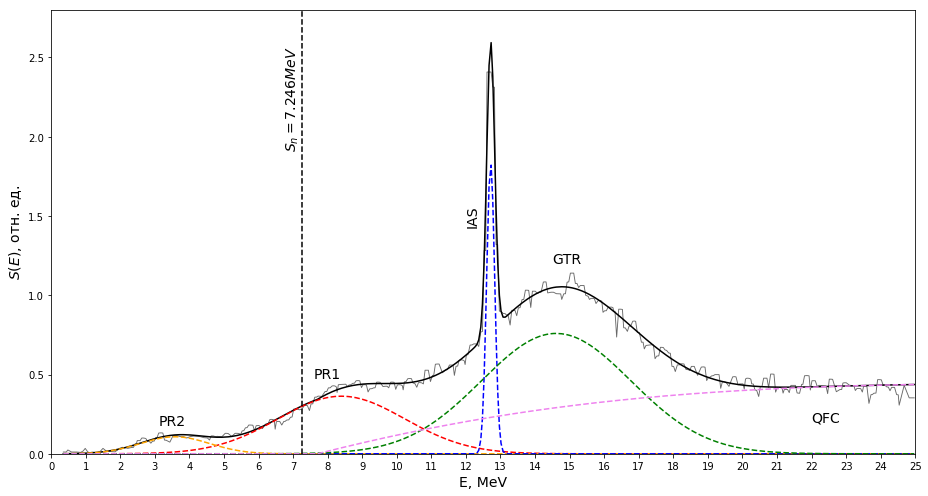

In [34]:
total_mod_gauss_comps = total_mod_gauss_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data1985['x'].values, data1985['y'].values, 'dimgrey', linewidth=0.9, label='experimental data')
plt.plot(data1985['x'].values, total_mod_gauss_result.best_fit, 'k', ls='-', label='total fit')
plt.plot(data1985['x'].values, total_mod_gauss_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
plt.plot(data1985['x'].values, total_mod_gauss_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
plt.plot(data1985['x'].values, total_mod_gauss_comps['IAS_'], 'b--', label='IAS')
plt.plot(data1985['x'].values, total_mod_gauss_comps['GTR_'], 'g--', label='GTR')
plt.plot(data1985['x'].values, total_mod_gauss_comps['QFC_'], 'violet', ls='--', label='QFC')

plt.axvline(S_n, c='black', ls='--',)
plt.text(S_n-0.5, 2.5, '$S_{n}=7.246 MeV$', rotation=90, fontsize=14)

plt.text(14.5, 1.2, 'GTR',  fontsize=14)
plt.text(22, 0.2, 'QFC',  fontsize=14)
plt.text(12.0, 1.5, 'IAS',  fontsize=14, rotation=90)
plt.text(3.1, 0.18, 'PR2',  fontsize=14)
plt.text(7.6, 0.48, 'PR1',  fontsize=14)

plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, отн. ед.', rotation=90, fontsize=14)
plt.ylim(0,2.8)
plt.xlim(0,25)
plt.xticks(np.arange(0,26,1))
#plt.show()
plt.tight_layout()
plt.savefig('Xe127_decomposition_gauss.png', format='png', dpi=500)

In [12]:
output = pd.DataFrame(data={'Ex, MeV':data1985['x'].values,
                            'y':total_mod_gauss_comps['pigmy1_']+
                           total_mod_gauss_comps['pigmy2_']+
                           total_mod_gauss_comps['GTR_']})
output.head()

,"Ex, MeV",y
0,0.350987,0.000607
1,0.434621,0.000790
2,0.482412,0.000916
3,0.589942,0.001268
4,0.733315,0.001921


In [13]:
outputIAS = pd.DataFrame(data={'Ex, MeV':data1985['x'].values,
                            'y':total_mod_gauss_comps['IAS_']})
outputIAS.head()

,"Ex, MeV",y
0,0.350987,0.0
1,0.434621,0.0
2,0.482412,0.0
3,0.589942,0.0
4,0.733315,0.0


### IAS width

In [17]:
IAS_for_peaks = np.interp(np.arange(11,15,0.001), data1985['x'].values, total_mod_gauss_comps['IAS_'])

peaks, _ = find_peaks(IAS_for_peaks)
results_half = peak_widths(IAS_for_peaks, peaks, rel_height=0.5)
results_half

(array([275.93497151]),
 array([0.91011546]),
 array([1578.02404294]),
 array([1853.95901446]))

In [19]:
IAS_for_peaks[peaks]

array([1.82023092])

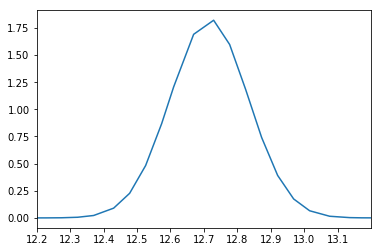

In [33]:
plt.plot( data1985['x'].values, total_mod_gauss_comps['IAS_'])
plt.xlim(12.2,13.2)
plt.xticks(np.arange(12.2,13.2, 0.1))
plt.show()

In [14]:
#outputIAS.to_excel('127Xe_gaussIAS.xls', index=False)
#output.to_excel('127Xe_gauss.xls', index=False)

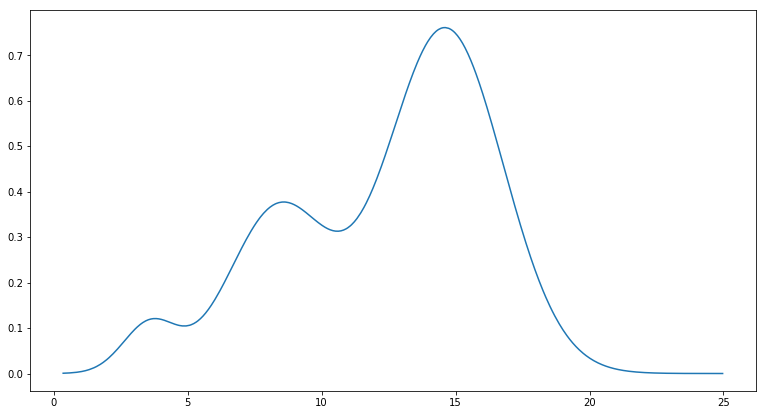

In [30]:
plt.figure(figsize=(13,7))
plt.plot(output['Ex, MeV'].values, output['y'].values)
plt.show()

In [31]:
10e01

100.0

In [32]:
bgt_full = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_bgt_full.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
bgt_0_5 = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_bgt_0_5l.csv', 
                      sep=';', decimal=',', names=['x', 'y'])

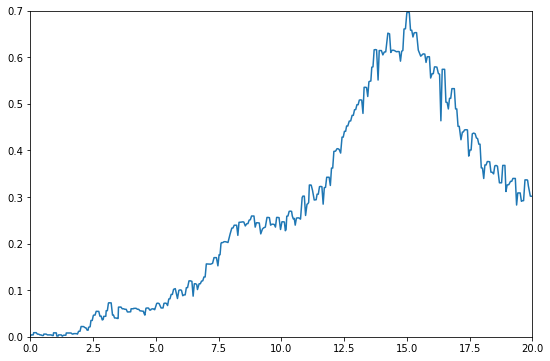

In [33]:
bgt = bgt_0_5.append(bgt_full[bgt_full['x']>5])

plt.figure(figsize=(9,6))
plt.plot(bgt['x'].values, bgt['y'].values)
plt.xlim(0,20)
plt.ylim(0,0.7)
plt.show()

In [34]:
trapz(bgt['y'].values, bgt['x'].values)

5.463277472256921

(0, 7)

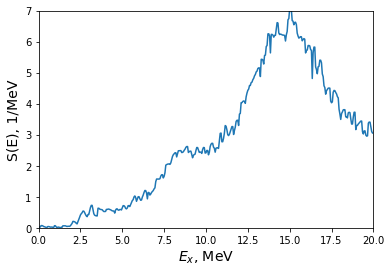

In [35]:
y_bgt = bgt['y'].values / trapz(bgt['y'].values, bgt['x'].values) \
* total_GT
#y_bgt_border = border_func(bgt['x'].values, y_bgt, S_n)

x_values = np.linspace(0,20, 401)
y_bgt_new = np.interp(x_values, bgt['x'].values, y_bgt)

plt.plot(x_values, y_bgt_new, )
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.xlim(0,20)
plt.ylim(0,7)

In [17]:
total_mod = Model(breit_vigner3,prefix='pigmy1_') \
+Model(breit_vigner3, prefix='pigmy2_') \
+Model(breit_vigner3, prefix='GTR_') \

total_mod.set_param_hint('pigmy1_w', value=9, min=5, max=11)
total_mod.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=1.5)
total_mod.set_param_hint('pigmy1_M', value=5, min=0.1, max=10)

total_mod.set_param_hint('pigmy2_w', value=4, min=2, max=5)
total_mod.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=1.5)
total_mod.set_param_hint('pigmy2_M', value=1, min=0.1, max=2)

total_mod.set_param_hint('GTR_w', value=15, min=11, max=16)
total_mod.set_param_hint('GTR_G1', value=2, min=2, max=5)
total_mod.set_param_hint('GTR_M', value=5, min=0.1, max= 30)

pars = total_mod.make_params()

total_mod_result = total_mod.fit(y_bgt_new, pars, x=x_values, 
                                 method='differential_evolution')

print(total_mod_result.fit_report())

[[Model]]
    ((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='pigmy2_')) + Model(breit_vigner3, prefix='GTR_'))
[[Fit Statistics]]
    # function evals   = 6301
    # data points      = 401
    # variables        = 9
    chi-square         = 20.359
    reduced chi-square = 0.052
    Akaike info crit   = -1177.152
    Bayesian info crit = -1141.206
[[Variables]]
    pigmy1_M:    0.82388298 (init= 5)
    pigmy1_w:    8.36703970 (init= 9)
    pigmy1_G1:   0.83547104 (init= 0.1)
    pigmy2_M:    0.14519850 (init= 1)
    pigmy2_w:    2.95966610 (init= 4)
    pigmy2_G1:   0.56070153 (init= 0.1)
    GTR_M:       24.3999604 (init= 5)
    GTR_w:       15.0916293 (init= 15)
    GTR_G1:      3.80914946 (init= 2)



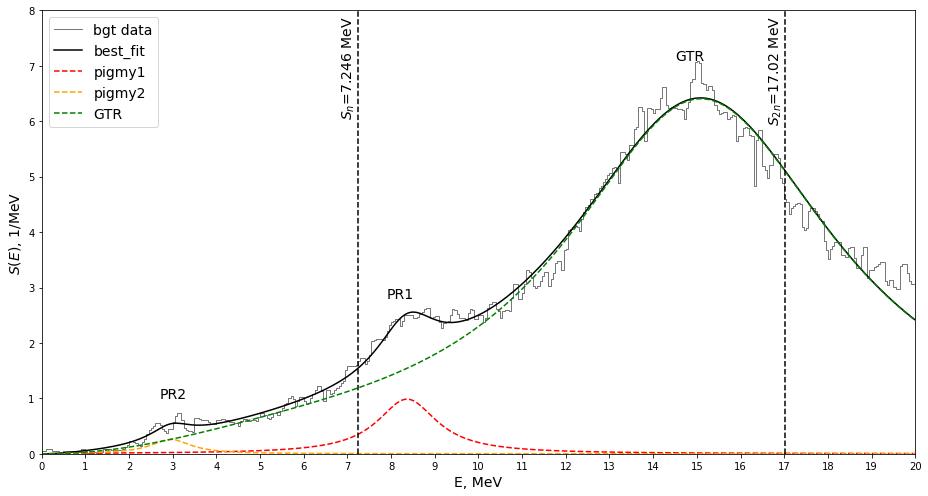

In [18]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.step(x_values, y_bgt_new, 'dimgrey', linewidth=0.9, label='bgt data')
plt.plot(x_values, total_mod_result.best_fit, 'k', ls='-', label='best_fit')
plt.plot(x_values, total_mod_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
plt.plot(x_values, total_mod_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
plt.plot(x_values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.legend(fontsize=14, loc='upper left')

plt.axvline(S_n, c='black', ls='--',)
plt.text(S_n-0.4, 7.7, '$S_{n}$=7.246 MeV', rotation=90, fontsize=14)
plt.axvline(S_2n, c='black', ls='--',)
plt.text(S_2n-0.4, 7.7, '$S_{2n}$=17.02 MeV', rotation=90, fontsize=14)


plt.text(14.5, 7.1, 'GTR',  fontsize=14)
plt.text(2.7, 1.0, 'PR2',  fontsize=14)
plt.text(7.9, 2.8, 'PR1',  fontsize=14)

plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, 1/MeV', rotation=90, fontsize=14)
plt.ylim(0,8)
plt.xlim(0,20)
plt.xticks(np.arange(0,21,1))
plt.tight_layout()
plt.savefig('Xe127_decomposition_BGT_2.png', format='png', dpi=500)
#plt.show()

## $\Gamma=\alpha E^2_x$

In [72]:
total_mod2_1 = Model(breit_vigner2_1,prefix='pigmy1_') \
+Model(breit_vigner2_1, prefix='pigmy2_') \
+Model(breit_vigner2_1, prefix='GTR_') \
#total_mod2_1 = Model(breit_vigner3,prefix='pigmy1_') \
#+Model(breit_vigner3, prefix='pigmy2_') \
#+Model(breit_vigner2_1, prefix='GTR_') \


total_mod2_1.set_param_hint('pigmy1_w', value=9, min=5, max=11)
total_mod2_1.set_param_hint('pigmy1_alpha', value=0.018, min=0.00001, max=11)
#total_mod2_1.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=1.5)
total_mod2_1.set_param_hint('pigmy1_M', value=5, min=0.1, max=10)

total_mod2_1.set_param_hint('pigmy2_w', value=4, min=2, max=5)
total_mod2_1.set_param_hint('pigmy2_alpha', expr='pigmy1_alpha')
#total_mod2_1.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=1.5)
total_mod2_1.set_param_hint('pigmy2_M', value=1, min=0.1, max=2)

total_mod2_1.set_param_hint('GTR_w', value=15, min=11, max=16)
total_mod2_1.set_param_hint('GTR_alpha', expr='pigmy1_alpha')
total_mod2_1.set_param_hint('GTR_M', value=5, min=0.1, max= 30)

pars = total_mod2_1.make_params()

total_mod2_1_result = total_mod2_1.fit(y_bgt_new, pars, x=x_values, 
                                 method='differential_evolution')

print(total_mod2_1_result.fit_report())

[[Model]]
    ((Model(breit_vigner2_1, prefix='pigmy1_') + Model(breit_vigner2_1, prefix='pigmy2_')) + Model(breit_vigner2_1, prefix='GTR_'))
[[Fit Statistics]]
    # function evals   = 6443
    # data points      = 401
    # variables        = 7
    chi-square         = 21.390
    reduced chi-square = 0.054
    Akaike info crit   = -1161.343
    Bayesian info crit = -1133.386
[[Variables]]
    pigmy1_M:       1.03818624 (init= 5)
    pigmy1_w:       8.33325644 (init= 9)
    pigmy1_alpha:   0.01650589 (init= 0.018)
    pigmy2_M:       0.10015667 (init= 1)
    pigmy2_w:       3.12703137 (init= 4)
    pigmy2_alpha:   0.01650589  == 'pigmy1_alpha'
    GTR_M:          24.1309931 (init= 5)
    GTR_w:          15.1148595 (init= 15)
    GTR_alpha:      0.01650589  == 'pigmy1_alpha'



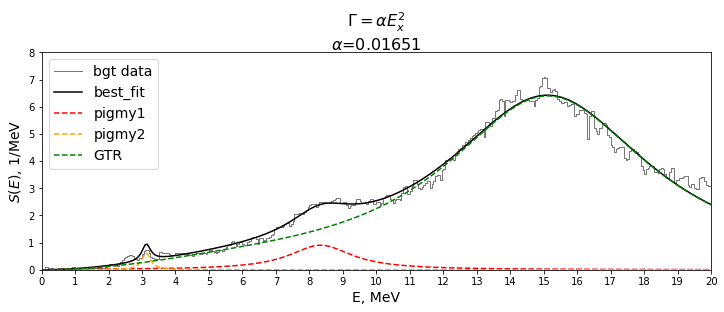

In [105]:
total_mod2_1_comps = total_mod2_1_result.eval_components()

plt.figure(figsize=(12,4))
#plt.plot(data['x'].values, data['y'].values)
plt.step(x_values, y_bgt_new, 'dimgrey', linewidth=0.9, label='bgt data')
plt.plot(x_values, total_mod2_1_result.best_fit, 'k', ls='-', label='best_fit')
plt.plot(x_values, total_mod2_1_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
plt.plot(x_values, total_mod2_1_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
plt.plot(x_values, total_mod2_1_comps['GTR_'], 'g--', label='GTR')
plt.legend(fontsize=14, loc='upper left')

#plt.axvline(S_n, c='black', ls='--',)
#plt.text(S_n-0.4, 7.7, '$S_{n}$=7.246 MeV', rotation=90, fontsize=14)
#plt.axvline(S_2n, c='black', ls='--',)
#plt.text(S_2n-0.4, 7.7, '$S_{2n}$=17.02 MeV', rotation=90, fontsize=14)


plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, 1/MeV', rotation=90, fontsize=14)
plt.ylim(0,8)
plt.xlim(0,20)

title1 = "$\Gamma=\\alpha E^2_x$"
title2 = '$\\alpha$={}'.format(total_mod2_1_result.best_values['pigmy1_alpha'].round(5))

#plt.title("$\Gamma=\\alpha E^2_x$", fontsize=16)
plt.title(title1+'\n'+title2, fontsize=16)
plt.xticks(np.arange(0,21,1))
#plt.tight_layout()
#plt.savefig('Xe127_decomposition_BGT_2.png', format='png', dpi=500)
plt.show()

## $\Gamma=\alpha E^2_x+\beta E^3$

In [99]:
total_mod2_2 = Model(breit_vigner2_2,prefix='pigmy1_') \
+Model(breit_vigner2_2, prefix='pigmy2_') \
+Model(breit_vigner2_2, prefix='GTR_') \
#total_mod2_1 = Model(breit_vigner3,prefix='pigmy1_') \
#+Model(breit_vigner3, prefix='pigmy2_') \
#+Model(breit_vigner2_1, prefix='GTR_') \


total_mod2_2.set_param_hint('pigmy1_w', value=9, min=5, max=11)
total_mod2_2.set_param_hint('pigmy1_alpha', min=0.00001, max=11)
total_mod2_2.set_param_hint('pigmy1_beta', value=0.018, min=0.00001, max=5)
#total_mod2_2.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=1.5)
total_mod2_2.set_param_hint('pigmy1_M', value=5, min=0.1, max=10)

total_mod2_2.set_param_hint('pigmy2_w', value=4, min=2, max=5)
total_mod2_2.set_param_hint('pigmy2_alpha', expr='pigmy1_alpha')
total_mod2_2.set_param_hint('pigmy2_beta', expr='pigmy1_beta')
#total_mod2_2.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=1.5)
total_mod2_2.set_param_hint('pigmy2_M', value=1, min=0.1, max=2)

total_mod2_2.set_param_hint('GTR_w', value=15, min=11, max=16)
total_mod2_2.set_param_hint('GTR_alpha', expr='pigmy1_alpha')
total_mod2_2.set_param_hint('GTR_beta', expr='pigmy1_beta')
total_mod2_2.set_param_hint('GTR_M', value=5, min=0.1, max= 30)

pars = total_mod2_2.make_params()

total_mod2_2_result = total_mod2_2.fit(y_bgt_new, pars, x=x_values, 
                                 method='differential_evolution')

print(total_mod2_2_result.fit_report())

[[Model]]
    ((Model(breit_vigner2_2, prefix='pigmy1_') + Model(breit_vigner2_2, prefix='pigmy2_')) + Model(breit_vigner2_2, prefix='GTR_'))
[[Fit Statistics]]
    # function evals   = 12682
    # data points      = 401
    # variables        = 8
    chi-square         = 21.233
    reduced chi-square = 0.054
    Akaike info crit   = -1162.299
    Bayesian info crit = -1130.348
[[Variables]]
    pigmy1_M:       0.95170251 (init= 5)
    pigmy1_w:       8.36192438 (init= 9)
    pigmy1_alpha:   0.01295838 (init= 1e-05)
    pigmy1_beta:    0.00023665 (init= 0.018)
    pigmy2_M:       0.10026855 (init= 1)
    pigmy2_w:       3.13858928 (init= 4)
    pigmy2_alpha:   0.01295838  == 'pigmy1_alpha'
    pigmy2_beta:    0.00023665  == 'pigmy1_beta'
    GTR_M:          24.1625431 (init= 5)
    GTR_w:          15.1023872 (init= 15)
    GTR_alpha:      0.01295838  == 'pigmy1_alpha'
    GTR_beta:       0.00023665  == 'pigmy1_beta'



In [140]:
0.01295838*15.1023872**2+0.00023665*15.1023872**3

3.7707353567520383

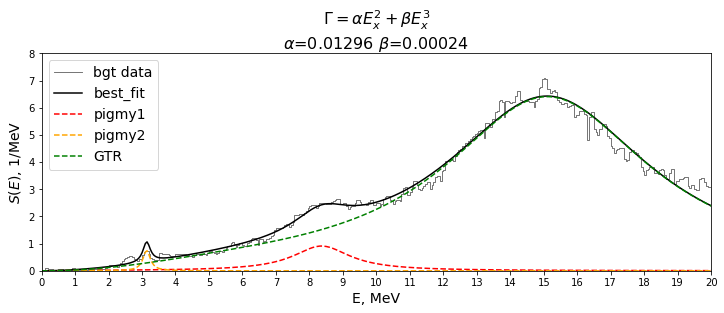

In [104]:
total_mod2_2_comps = total_mod2_2_result.eval_components()

plt.figure(figsize=(12,4))
#plt.plot(data['x'].values, data['y'].values)
plt.step(x_values, y_bgt_new, 'dimgrey', linewidth=0.9, label='bgt data')
plt.plot(x_values, total_mod2_2_result.best_fit, 'k', ls='-', label='best_fit')
plt.plot(x_values, total_mod2_2_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
plt.plot(x_values, total_mod2_2_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
plt.plot(x_values, total_mod2_2_comps['GTR_'], 'g--', label='GTR')
plt.legend(fontsize=14, loc='upper left')

#plt.axvline(S_n, c='black', ls='--',)
#plt.text(S_n-0.4, 7.7, '$S_{n}$=7.246 MeV', rotation=90, fontsize=14)
#plt.axvline(S_2n, c='black', ls='--',)
#plt.text(S_2n-0.4, 7.7, '$S_{2n}$=17.02 MeV', rotation=90, fontsize=14)


plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, 1/MeV', rotation=90, fontsize=14)
plt.ylim(0,8)
plt.xlim(0,20)

title1 = "$\Gamma=\\alpha E^2_x+\\beta E^3_x$"
title2 = '$\\alpha$={}'.format(total_mod2_2_result.best_values['pigmy1_alpha'].round(5))
title3 = '$\\beta$={}'.format(total_mod2_2_result.best_values['pigmy1_beta'].round(5))

plt.title(title1+'\n'+title2+' '+title3, fontsize=16)
plt.xticks(np.arange(0,21,1))
#plt.tight_layout()
#plt.savefig('Xe127_decomposition_BGT_2.png', format='png', dpi=500)
plt.show()

## $\Gamma=\alpha E^2_x-\beta E^3$

In [117]:
total_mod2_3 = Model(breit_vigner2_3,prefix='pigmy1_') \
+Model(breit_vigner2_3, prefix='pigmy2_') \
+Model(breit_vigner2_3, prefix='GTR_') \
#total_mod2_1 = Model(breit_vigner3,prefix='pigmy1_') \
#+Model(breit_vigner3, prefix='pigmy2_') \
#+Model(breit_vigner2_1, prefix='GTR_') \


total_mod2_3.set_param_hint('pigmy1_w', value=9, min=7, max=11)
total_mod2_3.set_param_hint('pigmy1_alpha', value=0.018, vary=False)
#total_mod2_3.set_param_hint('pigmy1_alpha', value=0.018, min=0.00001, max=11)
total_mod2_3.set_param_hint('pigmy1_beta', value=0.018, min=0.00001, max=5)
#total_mod2_2.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=1.5)
total_mod2_3.set_param_hint('pigmy1_M', value=5, min=0.1, max=10)

total_mod2_3.set_param_hint('pigmy2_w', value=4, min=2, max=5)
total_mod2_3.set_param_hint('pigmy2_alpha', expr='pigmy1_alpha')
total_mod2_3.set_param_hint('pigmy2_beta', expr='pigmy1_beta')
#total_mod2_2.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=1.5)
total_mod2_3.set_param_hint('pigmy2_M', value=1, min=0.1, max=2)

total_mod2_3.set_param_hint('GTR_w', value=15, min=11, max=16)
total_mod2_3.set_param_hint('GTR_alpha', expr='pigmy1_alpha')
total_mod2_3.set_param_hint('GTR_beta', expr='pigmy1_beta')
total_mod2_3.set_param_hint('GTR_M', value=5, min=0.1, max= 30)

pars = total_mod2_3.make_params()

total_mod2_3_result = total_mod2_3.fit(y_bgt_new, pars, x=x_values, 
                                 method='differential_evolution')

print(total_mod2_3_result.fit_report())

[[Model]]
    ((Model(breit_vigner2_3, prefix='pigmy1_') + Model(breit_vigner2_3, prefix='pigmy2_')) + Model(breit_vigner2_3, prefix='GTR_'))
[[Fit Statistics]]
    # function evals   = 5781
    # data points      = 401
    # variables        = 7
    chi-square         = 21.627
    reduced chi-square = 0.055
    Akaike info crit   = -1156.919
    Bayesian info crit = -1128.961
[[Variables]]
    pigmy1_M:       1.02904436 (init= 5)
    pigmy1_w:       8.27969375 (init= 9)
    pigmy1_alpha:   0.018 (fixed)
    pigmy1_beta:    0.00010284 (init= 0.018)
    pigmy2_M:       0.10727460 (init= 1)
    pigmy2_w:       3.13064150 (init= 4)
    pigmy2_alpha:   0.01800000  == 'pigmy1_alpha'
    pigmy2_beta:    0.00010284  == 'pigmy1_beta'
    GTR_M:          24.0504737 (init= 5)
    GTR_w:          15.1041305 (init= 15)
    GTR_alpha:      0.01800000  == 'pigmy1_alpha'
    GTR_beta:       0.00010284  == 'pigmy1_beta'



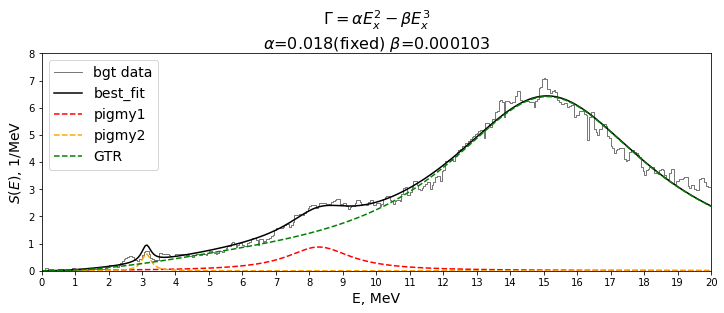

In [122]:
total_mod2_3_comps = total_mod2_3_result.eval_components()

plt.figure(figsize=(12,4))
#plt.plot(data['x'].values, data['y'].values)
plt.step(x_values, y_bgt_new, 'dimgrey', linewidth=0.9, label='bgt data')
plt.plot(x_values, total_mod2_3_result.best_fit, 'k', ls='-', label='best_fit')
plt.plot(x_values, total_mod2_3_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
plt.plot(x_values, total_mod2_3_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
plt.plot(x_values, total_mod2_3_comps['GTR_'], 'g--', label='GTR')
plt.legend(fontsize=14, loc='upper left')

#plt.axvline(S_n, c='black', ls='--',)
#plt.text(S_n-0.4, 7.7, '$S_{n}$=7.246 MeV', rotation=90, fontsize=14)
#plt.axvline(S_2n, c='black', ls='--',)
#plt.text(S_2n-0.4, 7.7, '$S_{2n}$=17.02 MeV', rotation=90, fontsize=14)


plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, 1/MeV', rotation=90, fontsize=14)
plt.ylim(0,8)
plt.xlim(0,20)

title1 = "$\Gamma=\\alpha E^2_x-\\beta E^3_x$"
title2 = '$\\alpha$={}'.format(total_mod2_3_result.best_values['pigmy1_alpha'])
title3 = '$\\beta$={}'.format(total_mod2_3_result.best_values['pigmy1_beta'].round(6))

plt.title(title1+'\n'+title2+'(fixed) '+title3, fontsize=16)
plt.xticks(np.arange(0,21,1))
#plt.tight_layout()
#plt.savefig('Xe127_decomposition_BGT_2.png', format='png', dpi=500)
plt.show()

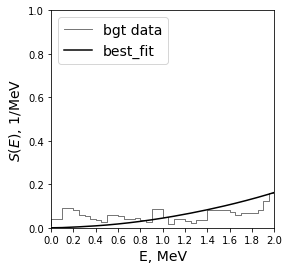

In [138]:


plt.figure(figsize=(4,4))
#plt.plot(data['x'].values, data['y'].values)
plt.step(x_values, y_bgt_new, 'dimgrey', linewidth=0.9, label='bgt data')
plt.plot(x_values, total_mod2_3_result.best_fit, 'k', ls='-', label='best_fit')
#plt.plot(x_values, total_mod2_3_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
#plt.plot(x_values, total_mod2_3_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
#plt.plot(x_values, total_mod2_3_comps['GTR_'], 'g--', label='GTR')
plt.legend(fontsize=14, loc='upper left')

#plt.axvline(S_n, c='black', ls='--',)
#plt.text(S_n-0.4, 7.7, '$S_{n}$=7.246 MeV', rotation=90, fontsize=14)
#plt.axvline(S_2n, c='black', ls='--',)
#plt.text(S_2n-0.4, 7.7, '$S_{2n}$=17.02 MeV', rotation=90, fontsize=14)


plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, 1/MeV', rotation=90, fontsize=14)
plt.ylim(0,1)
plt.xlim(0,2)

title1 = "$\Gamma=\\alpha E^2_x-\\beta E^3_x$"
title2 = '$\\alpha$={}'.format(total_mod2_3_result.best_values['pigmy1_alpha'])
title3 = '$\\beta$={}'.format(total_mod2_3_result.best_values['pigmy1_beta'].round(6))

#plt.title(title1+'\n'+title2+'(fixed) '+title3, fontsize=16)
plt.xticks(np.arange(0,2.2,0.2))
#plt.tight_layout()
#plt.savefig('Xe127_decomposition_BGT_2.png', format='png', dpi=500)
plt.show()

In [153]:
output = pd.DataFrame(data={'Ex, MeV':x_values,
                            "bgt":y_bgt_new,
                            'alpha E^2':total_mod2_1_result.best_fit,
                            'alpha E^2+beta E^3':total_mod2_2_result.best_fit,
                            'alpha E^2-beta E^3':total_mod2_3_result.best_fit,
                            'GTR (alpha E^2)':total_mod2_1_comps['GTR_'],
                            'PR1 (alpha E^2)':total_mod2_1_comps['pigmy1_'],
                            'PR2 (alpha E^2)':total_mod2_1_comps['pigmy2_'],
                            })
output.head()

,"Ex, MeV",GTR (alpha E^2),PR1 (alpha E^2),PR2 (alpha E^2),alpha E^2,alpha E^2+beta E^3,alpha E^2-beta E^3,bgt
0,0.00,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.014032
1,0.05,0.00007,0.00003,0.00016,0.00026,0.00028,0.00026,0.041647
2,0.10,0.00027,0.00013,0.00056,0.00096,0.00102,0.00097,0.041647
3,0.15,0.00060,0.00030,0.00105,0.00195,0.00198,0.00200,0.089973
4,0.20,0.00108,0.00053,0.00148,0.00309,0.00300,0.00319,0.089973


In [154]:
output.to_excel('127Xe_decomp_find_coeff.xls', index=False)

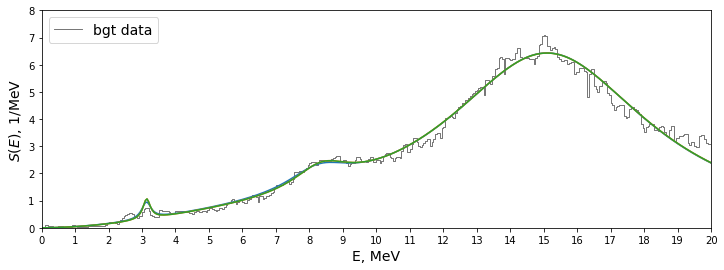

In [137]:
total_mod2_3_comps = total_mod2_3_result.eval_components()

plt.figure(figsize=(12,4))
#plt.plot(data['x'].values, data['y'].values)
plt.step(x_values, y_bgt_new, 'dimgrey', linewidth=0.9, label='bgt data')
plt.plot(x_values, total_mod2_3_result.best_fit,)
plt.plot(x_values, total_mod2_2_result.best_fit,)
plt.plot(x_values, total_mod2_2_result.best_fit,)
plt.legend(fontsize=14, loc='upper left')

#plt.axvline(S_n, c='black', ls='--',)
#plt.text(S_n-0.4, 7.7, '$S_{n}$=7.246 MeV', rotation=90, fontsize=14)
#plt.axvline(S_2n, c='black', ls='--',)
#plt.text(S_2n-0.4, 7.7, '$S_{2n}$=17.02 MeV', rotation=90, fontsize=14)


plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, 1/MeV', rotation=90, fontsize=14)
plt.ylim(0,8)
plt.xlim(0,20)

plt.xticks(np.arange(0,21,1))
#plt.tight_layout()
#plt.savefig('Xe127_decomposition_BGT_2.png', format='png', dpi=500)
plt.show()

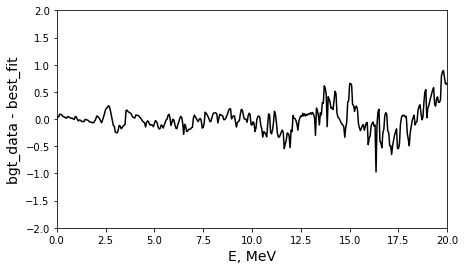

In [150]:


plt.figure(figsize=(7,4))
#plt.plot(data['x'].values, data['y'].values)
a = y_bgt_new - total_mod2_1_result.best_fit
#plt.step(x_values, y_bgt_new, 'dimgrey', linewidth=0.9, label='bgt data')
plt.plot(x_values, a, 'k', ls='-',)
#plt.plot(x_values, total_mod2_3_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
#plt.plot(x_values, total_mod2_3_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
#plt.plot(x_values, total_mod2_3_comps['GTR_'], 'g--', label='GTR')
#plt.legend(fontsize=14, loc='upper left')

plt.xlabel('E, MeV',fontsize=14)
plt.ylabel('bgt_data - best_fit', fontsize=14)
#plt.ylabel('$S(E)$, 1/MeV', rotation=90, fontsize=14)
plt.ylim(-2,2)
plt.xlim(0,20)

#plt.title(title1+'\n'+title2+'(fixed) '+title3, fontsize=16)
#plt.xticks(np.arange(0,2.2,0.2))
#plt.tight_layout()
#plt.savefig('Xe127_decomposition_BGT_2.png', format='png', dpi=500)
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


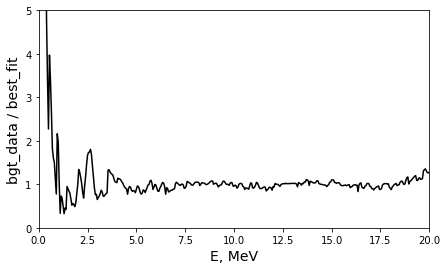

In [152]:
plt.figure(figsize=(7,4))
#plt.plot(data['x'].values, data['y'].values)
a = y_bgt_new / total_mod2_1_result.best_fit
#plt.step(x_values, y_bgt_new, 'dimgrey', linewidth=0.9, label='bgt data')
plt.plot(x_values, a, 'k', ls='-',)
#plt.plot(x_values, total_mod2_3_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
#plt.plot(x_values, total_mod2_3_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
#plt.plot(x_values, total_mod2_3_comps['GTR_'], 'g--', label='GTR')
#plt.legend(fontsize=14, loc='upper left')

plt.xlabel('E, MeV',fontsize=14)
plt.ylabel('bgt_data / best_fit', fontsize=14)
#plt.ylabel('$S(E)$, 1/MeV', rotation=90, fontsize=14)
plt.ylim(0,5)
plt.xlim(0,20)

#plt.title(title1+'\n'+title2+'(fixed) '+title3, fontsize=16)
#plt.xticks(np.arange(0,2.2,0.2))
#plt.tight_layout()
#plt.savefig('Xe127_decomposition_BGT_2.png', format='png', dpi=500)
plt.show()

## Матричные элементы от ЮС

In [39]:
En = np.array([0.2, 0.54, 1.58, 1.97, 2.76, 3.08, 3.45, 6.0, 8.34, 14.8, 20.59, 20.94, \
               21.09, 21.22, 29.70])

Mn = 2*np.array([0.0025, 0.0025, 0.01, 0.01, 0.02, 0.10, 0.01, 0.2, 1.2, 30.8, 0.5, 0.8, \
               0.5, 1.03, 6.3])

np.sum(Mn)

82.97

In [53]:
Mn2 = 2*np.array([0.0005,0.0025,0.01,0.01,0.02,0.15,0.01,0.157,0.0,1.16,0.0,0,0.0,0.0,
                29.15,0.7,0.6,0.2,0.6,0.4,1.03,1.4,0.82,0.4,3.49])
En2 = np.array([0.2,1.54,1.58,1.97,2.76,3.08,3.45,6.0,6.64,8.32,9.92,12.75,
               13.7,14.05,14.4,15.78,18.71,18.59,18.94,19.09,19.22,19.78,20.23,21.47,24.70])


In [72]:
Ex = np.arange(0,40,0.01)
w = En[0:15]
M_square = Mn[0:15]
alpha = 0.0165


norm_factors = []
for w_i,M_i in zip(w, M_square):
    y_values = breit_vigner3(Ex, 1, w_i, alpha*w_i**2)
    norm_factors.append(trapz(y_values, Ex))

plots = np.zeros((w.shape[0], Ex.shape[0]))
for idx, w_i, M_i, norm_i in zip(range(w.shape[0]), w, M_square, norm_factors):
    amplitude = M_i / norm_i
    y_values = breit_vigner3(Ex, amplitude, w_i, alpha*w_i**2)
    plots[idx] = y_values
    
summ = np.sum(plots, axis=0)

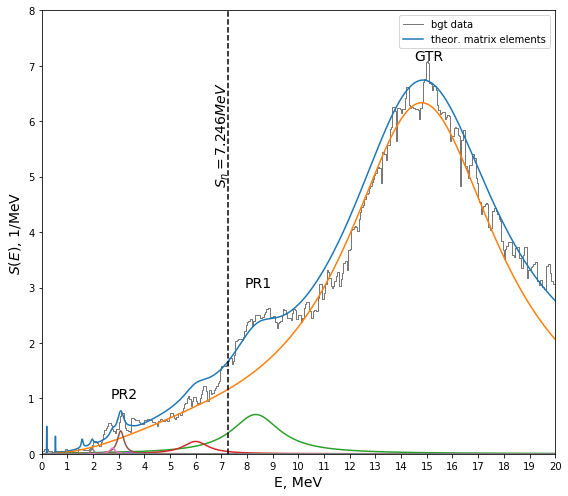

In [73]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(8,7))
#plt.plot(data['x'].values, data['y'].values)
plt.step(x_values, y_bgt_new, 'dimgrey', linewidth=0.9, label='bgt data')
#plt.plot(x_values, total_mod_result.best_fit, 'k', ls='-', label='best_fit')
#plt.plot(x_values, total_mod_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
#plt.plot(x_values, total_mod_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
#plt.plot(x_values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(Ex, summ, label='theor. matrix elements')
plt.plot(Ex, plots[9])
plt.plot(Ex, plots[8])
plt.plot(Ex, plots[7])
plt.plot(Ex, plots[6])
plt.plot(Ex, plots[5])
plt.plot(Ex, plots[4])
plt.plot(Ex, plots[3])
plt.legend()
plt.axvline(S_n, c='black', ls='--',)
plt.text(S_n-0.5, 6.5, '$S_{n}=7.246 MeV$', rotation=90, fontsize=14)

plt.text(14.5, 7.1, 'GTR',  fontsize=14)
plt.text(2.7, 1.0, 'PR2',  fontsize=14)
plt.text(7.9, 3, 'PR1',  fontsize=14)

plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, 1/MeV', rotation=90, fontsize=14)
plt.ylim(0,8)
plt.xlim(0,20)
plt.xticks(np.arange(0,21,1))
#plt.show()
plt.tight_layout()
#plt.savefig('Xe127_decomposition_BGT.png', format='png', dpi=500)

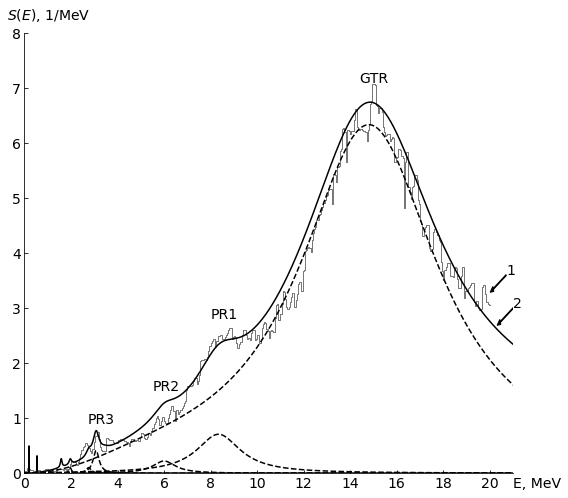

In [169]:
total_mod_comps = total_mod_result.eval_components()

f, ax = plt.subplots(figsize=(8,7))
#plt.plot(data['x'].values, data['y'].values)
plt.step(x_values, y_bgt_new, c='dimgray', linewidth=0.9, label='bgt data')
plt.plot(Ex, summ, c='black', ls='-')
plt.plot(Ex, plots[9], c='black', ls='--')
plt.plot(Ex, plots[8], c='black', ls='--')
plt.plot(Ex, plots[7], c='black', ls='--')
plt.plot(Ex, plots[6], c='black', ls='--')
plt.plot(Ex, plots[5], c='black', ls='--')
plt.plot(Ex, plots[4], c='black', ls='--')
plt.plot(Ex, plots[3], c='black', ls='--')

ax.tick_params(direction='in', labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('$S(E)$, 1/MeV', rotation=0, fontsize=14)
ax.yaxis.set_label_coords(0.05,1.02)
ax.set_xlabel('E, MeV', fontsize=14)
ax.xaxis.set_label_coords(1.05,-0.008)

ax.arrow(21, 3.0, -0.55, -0.25, head_width=0.1, width=0.02, fc='k', ec='k')
plt.text(21, 3.0, '2',  fontsize=14)
ax.arrow(20.7, 3.6, -0.55, -0.25, head_width=0.1, width=0.02,fc='k', ec='k')
plt.text(20.7, 3.6, '1',  fontsize=14)

plt.text(14.4, 7.1, 'GTR',  fontsize=14)
plt.text(7.99, 2.8, 'PR1',  fontsize=14)
plt.text(5.5, 1.5, 'PR2',  fontsize=14)
plt.text(2.7, 0.9, 'PR3',  fontsize=14)

#plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
#plt.ylabel('$S(E)$, 1/MeV', fontsize=14)
plt.ylim(0,8)
plt.xlim(0,21)
plt.xticks(np.arange(0,21,2))
#plt.show()
plt.tight_layout()
plt.savefig('Xe127_decomposition_BGT.svg', format='svg',)

In [23]:
output = pd.DataFrame(data={'Ex, MeV':x_values,
                            "bgt":y_bgt_new,
                            "best_fit":total_mod_result.best_fit,
                            'pr1':total_mod_comps['pigmy1_'],
                            "pr2":total_mod_comps['pigmy2_'],
                            "gtr":total_mod_comps['GTR_']})
output.head()

,"Ex, MeV",best_fit,bgt,gtr,pr1,pr2
0,0.00,0.00000,0.014032,0.00000,0.00000,0.00000
1,0.05,0.00018,0.041647,0.00007,0.00004,0.00007
2,0.10,0.00071,0.041647,0.00027,0.00014,0.00030
3,0.15,0.00162,0.089973,0.00061,0.00032,0.00069
4,0.20,0.00288,0.089973,0.00108,0.00057,0.00123


In [25]:
output.to_excel('127Xe_bgt_decomp.xls', index=False)

In [194]:
#y_bgt_new[:-1].reshape((20,20))

In [195]:
#y_bgt_new[:-1].reshape((20,20))[:,-1]

In [179]:
np.cumsum(y_bgt_new[1:]).shape

(400,)

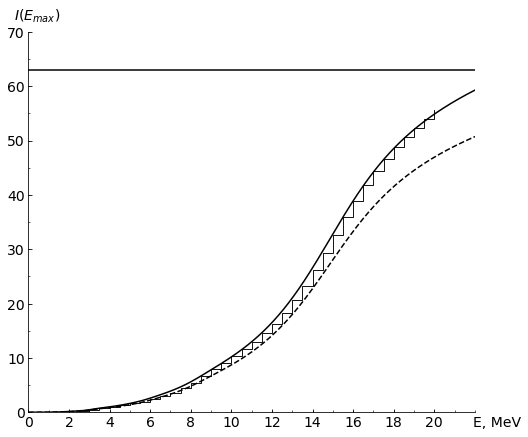

In [229]:
f, ax = plt.subplots(figsize=(8,7))
plt.step(x_values[1:].reshape((40,10))[:,-1], cumtrapz(y_bgt_new, x_values).reshape((40,10))[:,-1], c='black', 
         linewidth=0.9, where='post')
plt.plot(Ex[1:], cumtrapz(0.935*summ, Ex), c='black')
plt.plot(Ex[1:], cumtrapz(0.8*summ, Ex), c='black', ls='--')
ax.hlines(63, 0,22)

ax.tick_params(direction='in', which='both',labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('$I(E_{max})$', rotation=0, fontsize=14)
ax.yaxis.set_label_coords(0.02,1.02)
ax.set_xlabel('E, MeV', fontsize=14)
ax.xaxis.set_label_coords(1.05,-0.008)

ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))

plt.xticks(np.arange(0,21,2))
plt.xlim(0,22)
plt.ylim(0,70)

#plt.grid(True)
plt.savefig('Xe127_cumsum.svg', format='svg',)

In [185]:
Ex[1], Ex[0]

(0.01, 0.0)